In [1]:
import os,sys,string, time
import ROOT
from math import *
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from root_pandas import read_root
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
import pickle

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
import Utilities.Functions as Functions

print ('Success')

Welcome to JupyROOT 6.24/06
Success


# Loading in the "results" dataframe after full selection

In [2]:
Run = "run1" #so far either "run1" or "run3"

HNL_masses = Constants.HNL_mass_samples

loc_pkl = f'pkl_files/{Run}/current_files/Results/'

overlay_results = pd.read_pickle(loc_pkl+"overlay_results.pkl") #This will contain all of the BDT output scores and rse_id

# Reading in the overlay .root file with reweight branches

In [3]:
sys_variables = Variables.sys_vars + Variables.event_vars + Variables.weight_related

if Run == "run1":
    NuMI_MC_overlay = uproot3.open('../NuMI_MC/SLIMMED_neutrinoselection_filt_run1_overlay.root')['nuselection/NeutrinoSelectionFilter']
    Norm = Constants.SF_overlay_run1
elif Run == "run3":
    NuMI_MC_overlay = uproot3.open('../NuMI_MC/SLIMMED_neutrinoselection_filt_run3_overlay.root')['nuselection/NeutrinoSelectionFilter']
    Constants.SF_overlay_run3

df_overlay_weights = NuMI_MC_overlay.pandas.df(sys_variables, flatten=False) #Perhaps I can do this in a more clever way than just making a dataframe


# Keeping only the events which pass selection in the weight dataframe

In [4]:
def make_unique_ev_id(df): #df must have 'run', 'sub' and 'evt' branches
    if pd.Series(['run', 'sub', 'evt']).isin(df.columns).all():
        rse_list = []
        for entry in df.index: #Looping over all events in the dataframe
            rse = str(df['run'][entry]) + "_" + str(df['sub'][entry]) + "_" + str(df['evt'][entry])
            rse_list.append(rse)
        df['rse_id'] = rse_list #Writing a new branch with the unique event id
        return df.copy()
    else:
        print("Dataframe needs \"run\", \"sub\" and \"evt\" columns.")
        return 0
    
def check_duplicate_events(df):
    rse_list = df['rse_id'].to_list()

    seen = set()
    dupes = []

    for x in rse_list:
        if x in seen:
            dupes.append(x)
        else:
            seen.add(x)
    print("Number of duplicates is " + str(len(dupes)))
    print("Number of unique events is " + str(len(seen)))

overlay_results_rse = make_unique_ev_id(overlay_results)
df_overlay_weights_rse = make_unique_ev_id(df_overlay_weights)

#Deleting any duplicates of events, should be able to avoid if correctly filtered for one event per row
overlay_results_rse.drop_duplicates(subset=['rse_id'], keep='first', inplace=True)

print("Number of events in weights file is " + str(len(df_overlay_weights_rse)))
print("Number of events in results file is " + str(len(overlay_results_rse)))

Number of events in weights file is 914729
Number of events in results file is 47855


In [5]:
#Keeping only those events in the final selection
filtered_weights = df_overlay_weights_rse.loc[(df_overlay_weights_rse['rse_id'].isin(overlay_results_rse['rse_id']))]

print("Number of events in the filtered weights file is " + str(len(filtered_weights)))
print("Number of events in results file is " + str(len(overlay_results_rse)))

Number of events in the filtered weights file is 47855
Number of events in results file is 47855


## Merging into one dataframe with results and weights

In [6]:
BDT_score_list = []

for HNL_mass in HNL_masses:
    BDT_score_list.append(f'BDT_output_{HNL_mass}MeV')

just_score_df = overlay_results_rse[BDT_score_list + ['rse_id','weight']].copy()

final_merged = pd.merge(filtered_weights,just_score_df, how='outer', on=['rse_id']) #This will have the reweighting branches AND BDT score branches


# Plotting the BDT score with all different multisims

In [14]:
def All_reweight_err(df, var_name, n_bins, x_range, Norm):
    results_dict = {}
    for Multisim in Constants.Multisim_univs:
        Nuniverse = Constants.Multisim_univs[Multisim]
        n_tot = np.empty([Nuniverse, n_bins])
        n_cv_tot = np.empty(n_bins)
        n_tot.fill(0)
        n_cv_tot.fill(0)
        
        variable = df[var_name] #The BDT output score
        syst_weights = df[Multisim] #An array of length of the number of events, each entry is an array of length Nunivs
        spline_fix_cv  = df["weight"]*Norm
        spline_fix_var = df["weight"]*Norm
        
        s = syst_weights
        df_weights = pd.DataFrame(s.values.tolist())
        n_cv, bins = np.histogram(variable, range=x_range, bins=n_bins, weights=spline_fix_cv)
        n_cv_tot += n_cv
        
        if(Multisim == "weightsGenie"): #special treatment as ["weightSplineTimesTune"] is included in genie weights
            if not df_weights.empty:
                for i in range(Nuniverse):
                    weight = df_weights[i].values / 1000.
                    weight[weight == 1]= df["weightSplineTimesTune"].iloc[weight == 1]
                    weight[np.isnan(weight)] = df["weightSplineTimesTune"].iloc[np.isnan(weight)]
                    weight[weight > 50] = df["weightSplineTimesTune"].iloc[weight > 50] # why 30 not 50?
                    weight[weight <= 0] = df["weightSplineTimesTune"].iloc[weight <= 0]
                    weight[weight == np.inf] = df["weightSplineTimesTune"].iloc[weight == np.inf]
                
                    n, bins = np.histogram(variable, 
                                           weights=np.nan_to_num(weight*spline_fix_var/df["weightSplineTimesTune"]), range=x_range, bins=n_bins)
                    n_tot[i] += n
                    
        if(Multisim == "weightsPPFX"): #special treatment as ["PPFXPcv"] is included in ppfx weights
            if not df_weights.empty:
                for i in range(Nuniverse):
                    weight = df_weights[i].values / 1000.
                    weight[weight == 1]= df["ppfx_cv"].iloc[weight == 1]
                    weight[np.isnan(weight)] = df["ppfx_cv"].iloc[np.isnan(weight)]
                    weight[weight > 100] = df["ppfx_cv"].iloc[weight > 100]
                    weight[weight < 0] = df["ppfx_cv"].iloc[weight < 0]
                    weight[weight == np.inf] = df["ppfx_cv"].iloc[weight == np.inf]
                
                    n, bins = np.histogram(variable, weights=weight*np.nan_to_num(spline_fix_var/df["ppfx_cv"]), range=x_range, bins=n_bins)
                    n_tot[i] += n
        
        if(Multisim == "weightsReint"):
            if not df_weights.empty:
                for i in range(Nuniverse):
                    weight = df_weights[i].values / 1000.
                    weight[np.isnan(weight)] = 1
                    weight[weight > 100] = 1
                    weight[weight < 0] = 1
                    weight[weight == np.inf] = 1
                    n, bins = np.histogram(variable, weights=weight*spline_fix_var, range=x_range, bins=n_bins)
                    n_tot[i] += n
        cov = np.empty([len(n_cv), len(n_cv)])
        cov.fill(0)

        for n in n_tot:
            for i in range(len(n_cv)):
                for j in range(len(n_cv)):
                    cov[i][j] += (n[i] - n_cv_tot[i]) * (n[j] - n_cv_tot[j])

        cov /= Nuniverse
        results_dict[Multisim] = [cov,n_cv_tot,n_tot,bins]
    return results_dict

In [15]:
results_dict = All_reweight_err(final_merged, 'BDT_output_50MeV', 20, [0,1.0], Norm)

In [63]:
def Plot_multisim(results_dict, HNL_mass):
    for Multisim in results_dict:
        Nuniverse = Constants.Multisim_univs[Multisim]
        cov = results_dict[Multisim][0]
        cv = results_dict[Multisim][1]
        n_tot = results_dict[Multisim][2]
        bins = results_dict[Multisim][3]
        
        fig,ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=[10,10],dpi=200)
        plt.sca(ax[0])

        bins=np.linspace(0,1.0,21)

        bins_cent=(bins[:-1]+bins[1:])/2
        bins_centlong=np.tile(bins_cent,Nuniverse)

        nybins=70

        plt.title(Multisim + " Variations",fontsize=20)

        plt.hist(bins_cent,bins,weights=cv,color="red",histtype="step",label="Central Value",lw=2,linestyle='-')
        plt.legend()
        bins_cent=(bins[:-1]+bins[1:])/2
        bins_centlong=np.tile(bins_cent,Nuniverse)

        plt.ylabel("Events")
        plt.hist2d(bins_centlong,n_tot.flatten(),bins=[bins,nybins],cmin=1,range=[[0,1.0],[0,max(cv)*1.4]],rasterized=True)

        plt.colorbar(pad=0,use_gridspec=True)
        #fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),pad=0,use_gridspec=True)
        # plt.yscale("log")
        plt.ylim(0,max(cv)*1.4)
        # plt.yscale("log")

        plt.sca(ax[1])
        
        #ax[1].tick_params(labelright=False, length=0)
        pos = ax[0].get_position()
        pos2 = ax[1].get_position()
        ax[1].set_position([pos.x0,pos2.y0,pos.width,pos2.height])
        
        plt.hist(bins_cent,bins,weights=np.sqrt(np.diag(cov))/cv*100,color="black",histtype="step",lw=3,linestyle='-')
        plt.ylim(0,30)
        plt.ylabel("% Uncertainity")
        #plt.yticks([])
        plt.xlabel(f"BDT score ({HNL_mass} MeV HNL) ",fontsize=25)


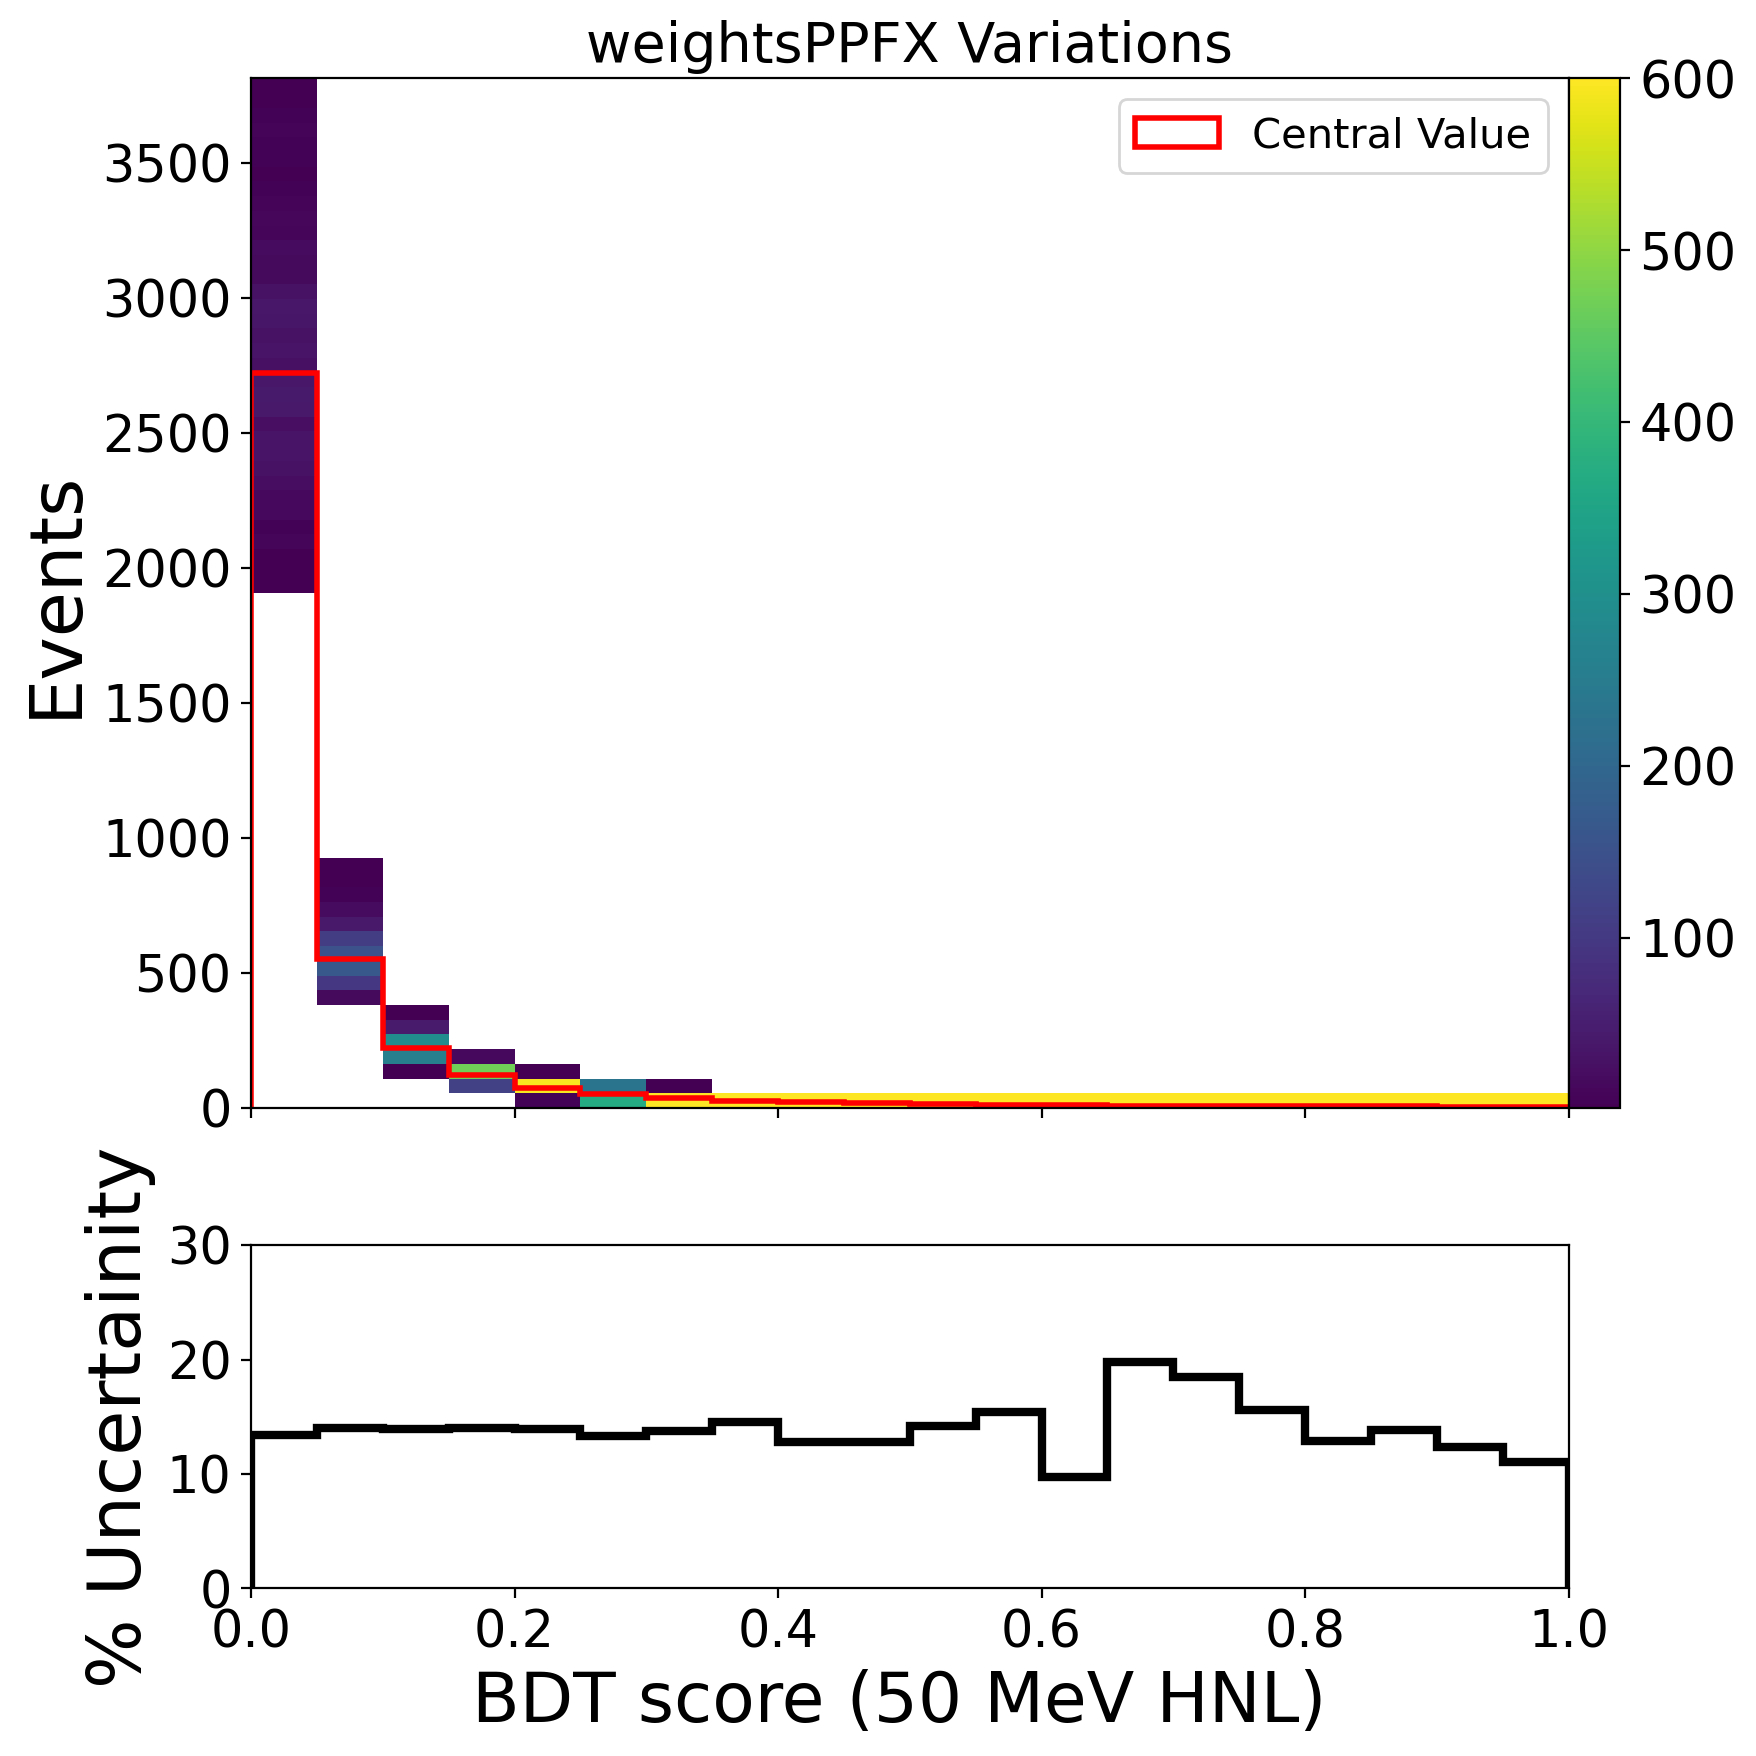

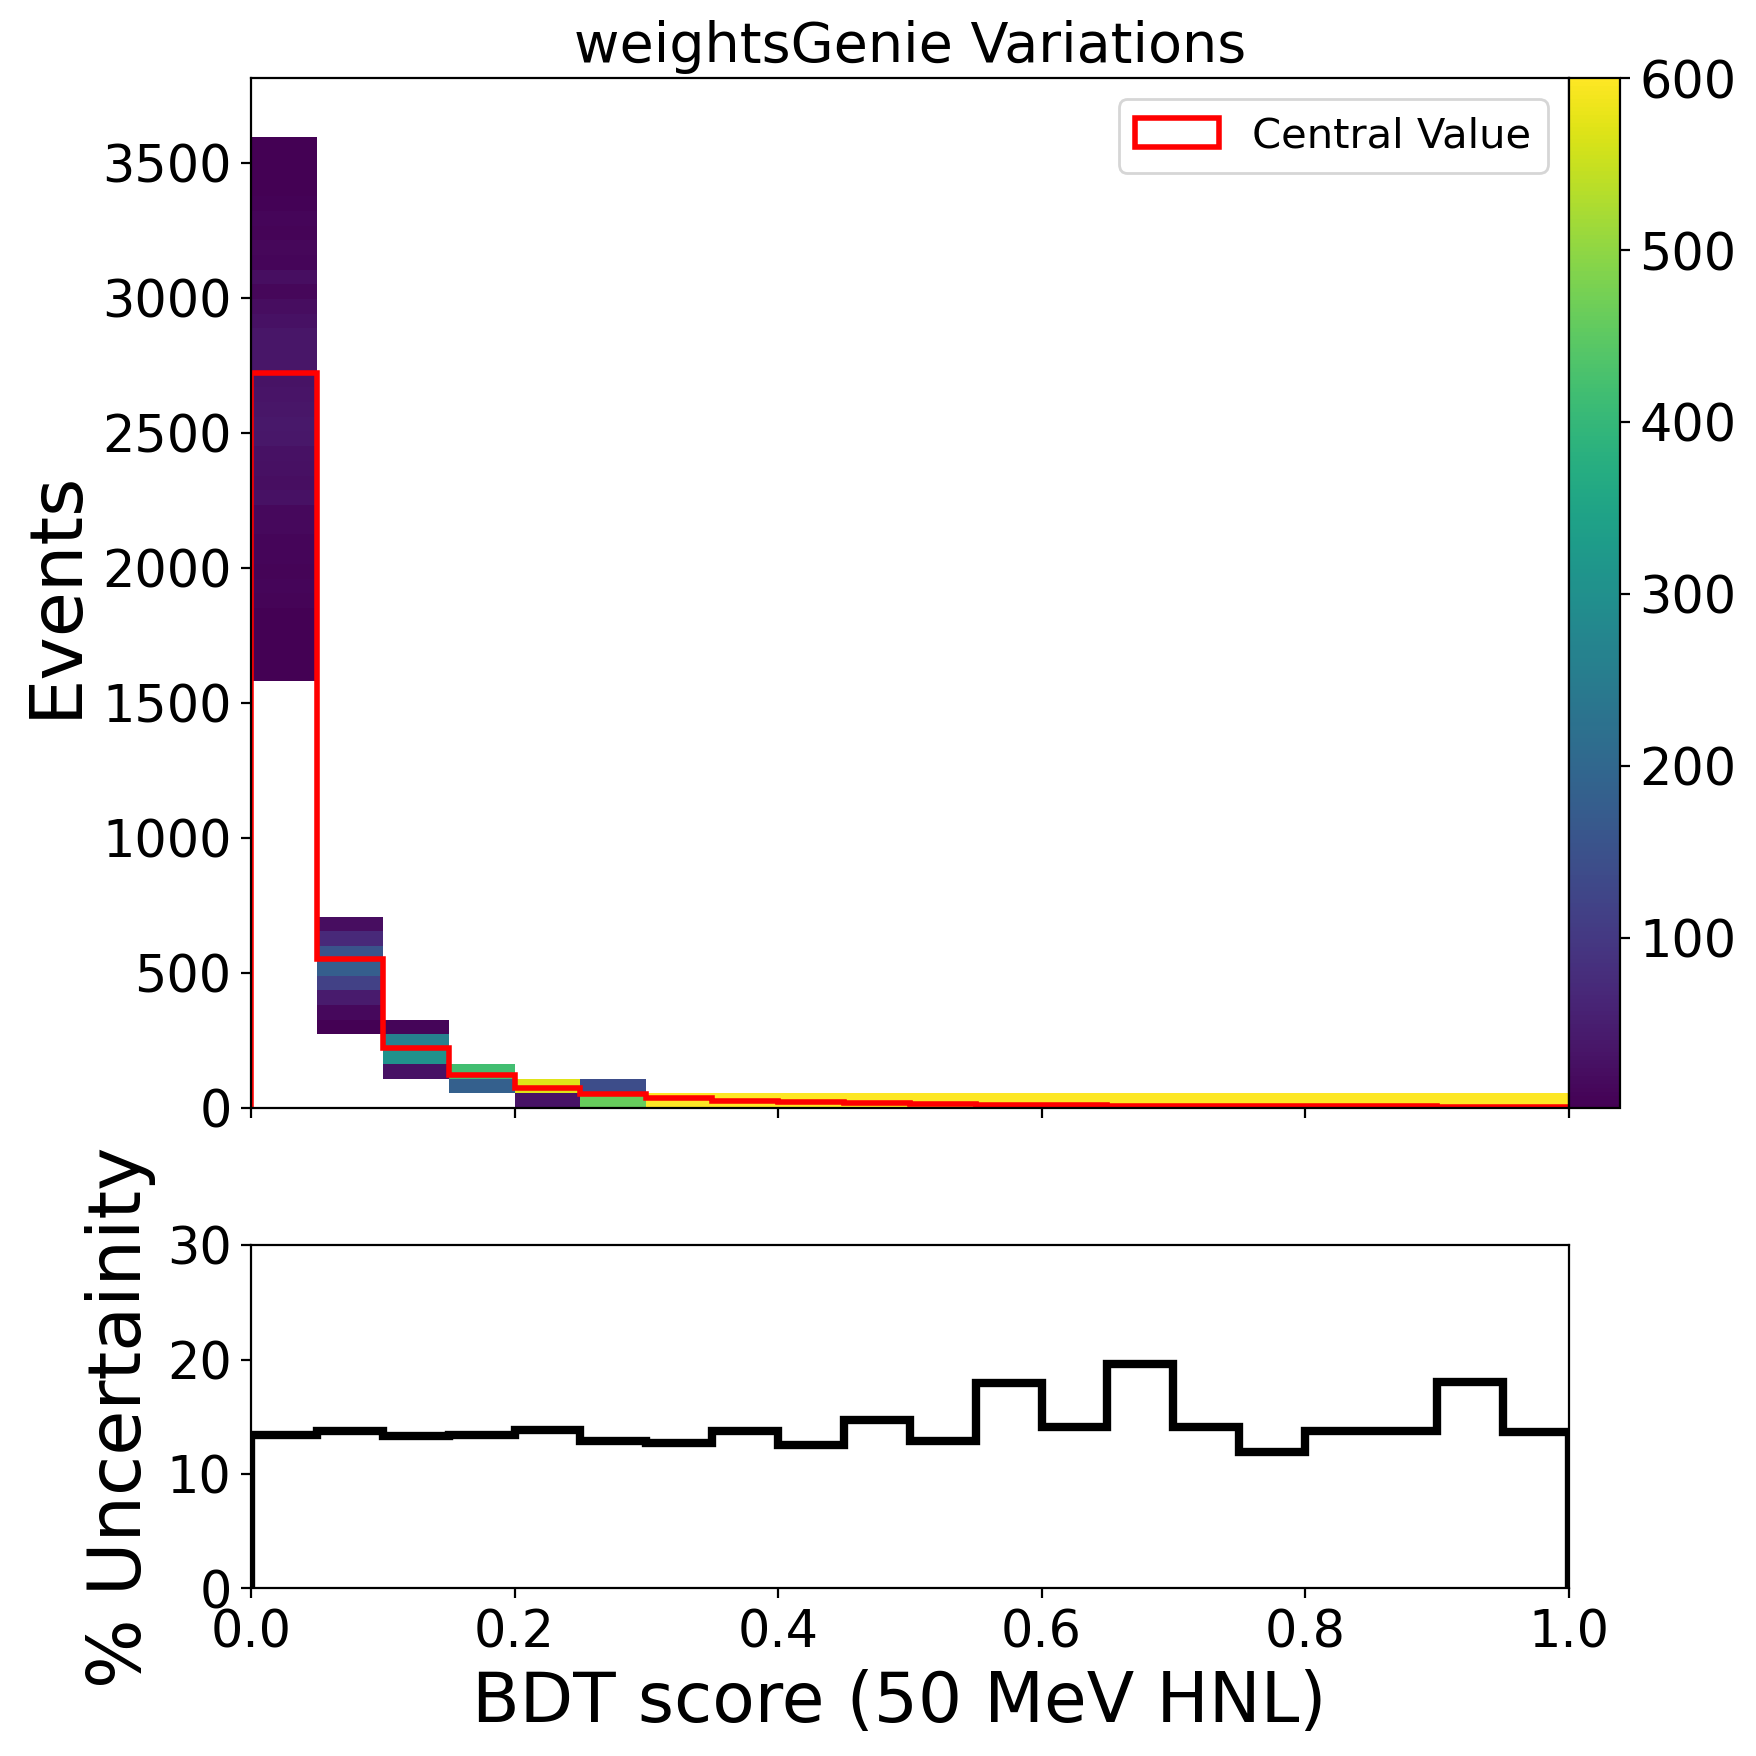

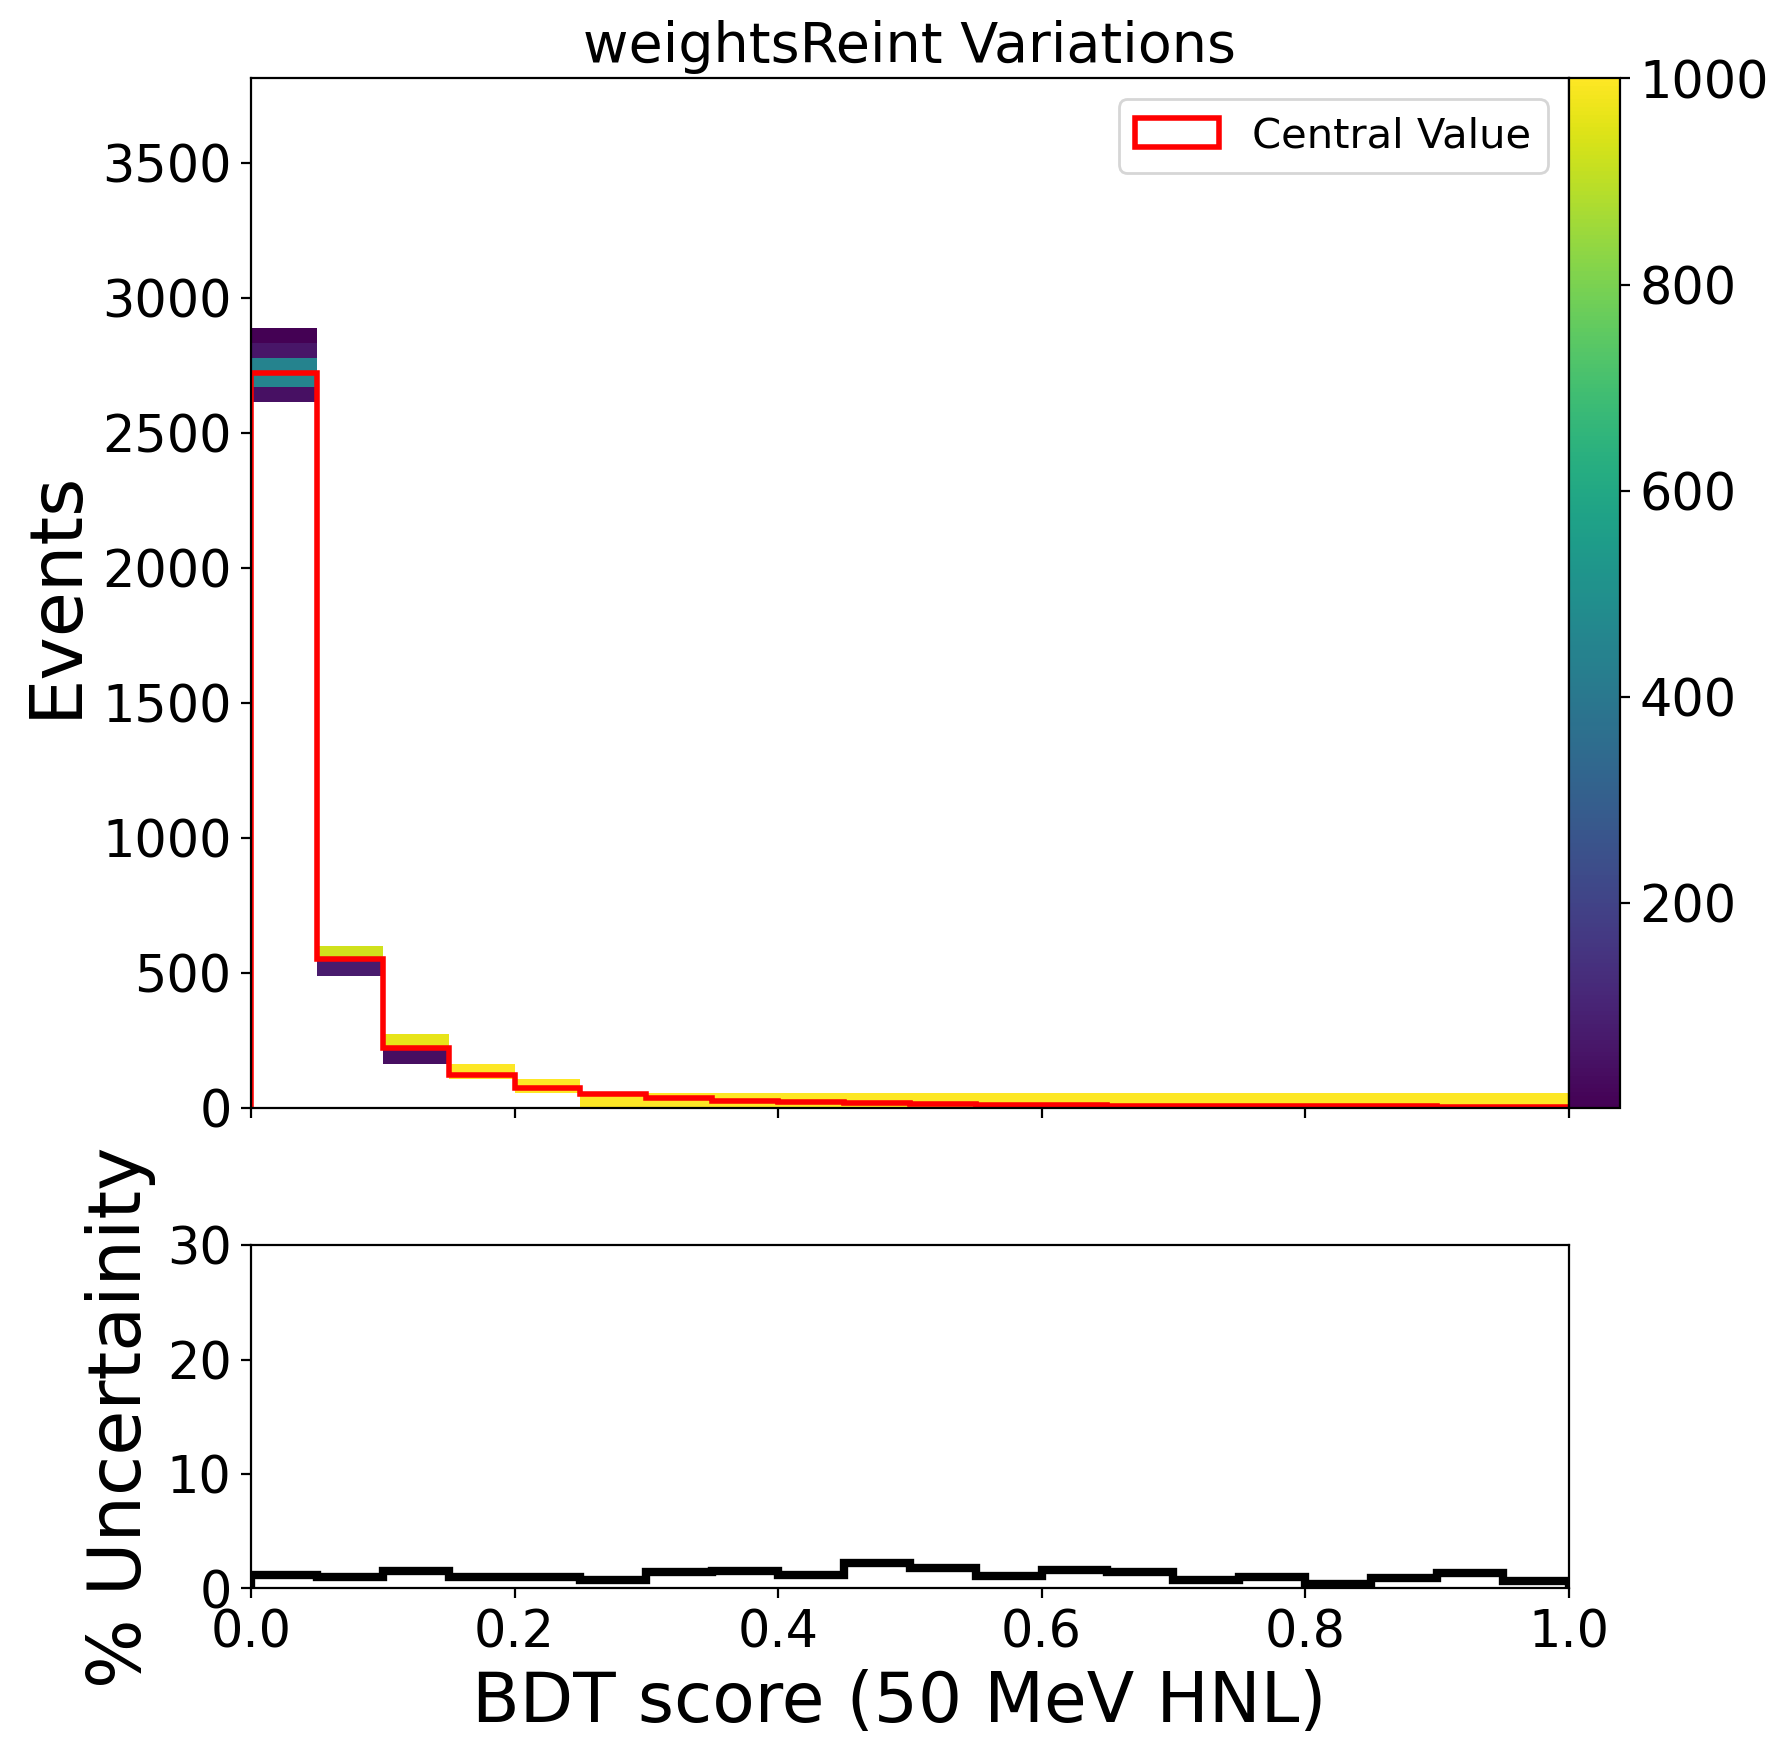

In [64]:
Plot_multisim(results_dict, 50)

In [8]:
def sys_err(sample, name, var_name, x_range, bins,NormScale): #This only does one at a time, would be nice to have a function which does all 3
    Nuniverse = Constants.Multisim_univs[name] 

    if(isinstance(bins, int)):n_bins=bins
    else: n_bins=len(bins)-1

    n_tot = np.empty([Nuniverse, n_bins])
    n_cv_tot = np.empty(n_bins)
    n_tot.fill(0)
    n_cv_tot.fill(0)

    variable = sample[var_name]
    syst_weights = sample[name]
    spline_fix_cv  = sample["weight"]*NormScale
    spline_fix_var = sample["weight"]*NormScale

    s = syst_weights
    df = pd.DataFrame(s.values.tolist())
    n_cv, bins = np.histogram(
        variable,
        range=x_range,
        bins=bins,
        weights=spline_fix_cv)
    n_cv_tot += n_cv
    
    if(name == "weightsGenie"): #special treatment as ["weightSplineTimesTune"] is included in genie weights
        if not df.empty:
            for i in range(Nuniverse):
                weight = df[i].values / 1000.
                weight[weight == 1]= sample["weightSplineTimesTune"].iloc[weight == 1]
                weight[np.isnan(weight)] = sample["weightSplineTimesTune"].iloc[np.isnan(weight)]
                #weight[weight > 30] = sample["weightSplineTimesTune"].iloc[weight > 30] #build up of events at 65 weight
                weight[weight > 50] = sample["weightSplineTimesTune"].iloc[weight > 50] # why 30 not 50?
                #weight[weight < 0] = sample["weightSplineTimesTune"].iloc[weight < 0] 
                weight[weight <= 0] = sample["weightSplineTimesTune"].iloc[weight <= 0]
                weight[weight == np.inf] = sample["weightSplineTimesTune"].iloc[weight == np.inf]
                
                n, bins = np.histogram(
                    variable, weights=np.nan_to_num(weight*spline_fix_var/sample["weightSplineTimesTune"]), range=x_range, bins=bins)
                n_tot[i] += n
                
    elif(name == "weightsPPFX"): #special treatment as ["PPFXPcv"] is included in ppfx weights
        if not df.empty:
            for i in range(Nuniverse):
                weight = df[i].values / 1000.
                weight[weight == 1]= sample["ppfx_cv"].iloc[weight == 1]
                weight[np.isnan(weight)] = sample["ppfx_cv"].iloc[np.isnan(weight)]
                weight[weight > 100] = sample["ppfx_cv"].iloc[weight > 100]
                weight[weight < 0] = sample["ppfx_cv"].iloc[weight < 0]
                weight[weight == np.inf] = sample["ppfx_cv"].iloc[weight == np.inf]
                
                n, bins = np.histogram(
                    variable, weights=weight*np.nan_to_num(spline_fix_var/sample["ppfx_cv"]), range=x_range, bins=bins)
                n_tot[i] += n
    else:       
        if not df.empty:
            for i in range(Nuniverse):
                weight = df[i].values / 1000.
                weight[np.isnan(weight)] = 1
                weight[weight > 100] = 1
                weight[weight < 0] = 1
                weight[weight == np.inf] = 1
                n, bins = np.histogram(
                    variable, weights=weight*spline_fix_var, range=x_range, bins=bins)
                n_tot[i] += n

    cov = np.empty([len(n_cv), len(n_cv)])
    cov.fill(0)

    for n in n_tot:
        for i in range(len(n_cv)):
            for j in range(len(n_cv)):
                cov[i][j] += (n[i] - n_cv_tot[i]) * (n[j] - n_cv_tot[j])

    cov /= Nuniverse
    return cov,n_cv_tot,n_tot,bins
  

In [9]:
# cov_ppfx,cv,n_tot_ppfx,bins=sys_err(final_merged,"weightsPPFX",'BDT_output_50MeV',[0,1.0],20,Constants.SF_overlay_run3)
cov_genie,cv_genie,n_tot_genie,bins=sys_err(final_merged,"weightsGenie",'BDT_output_50MeV',[0,1.0],20,Constants.SF_overlay_run3)
# cov_reint,cv_reint,n_tot_reint,bins_reint=sys_err(final_merged,"weightsReint",'BDT_output_50MeV',[0,1.0],20,Constants.SF_overlay_run3)

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


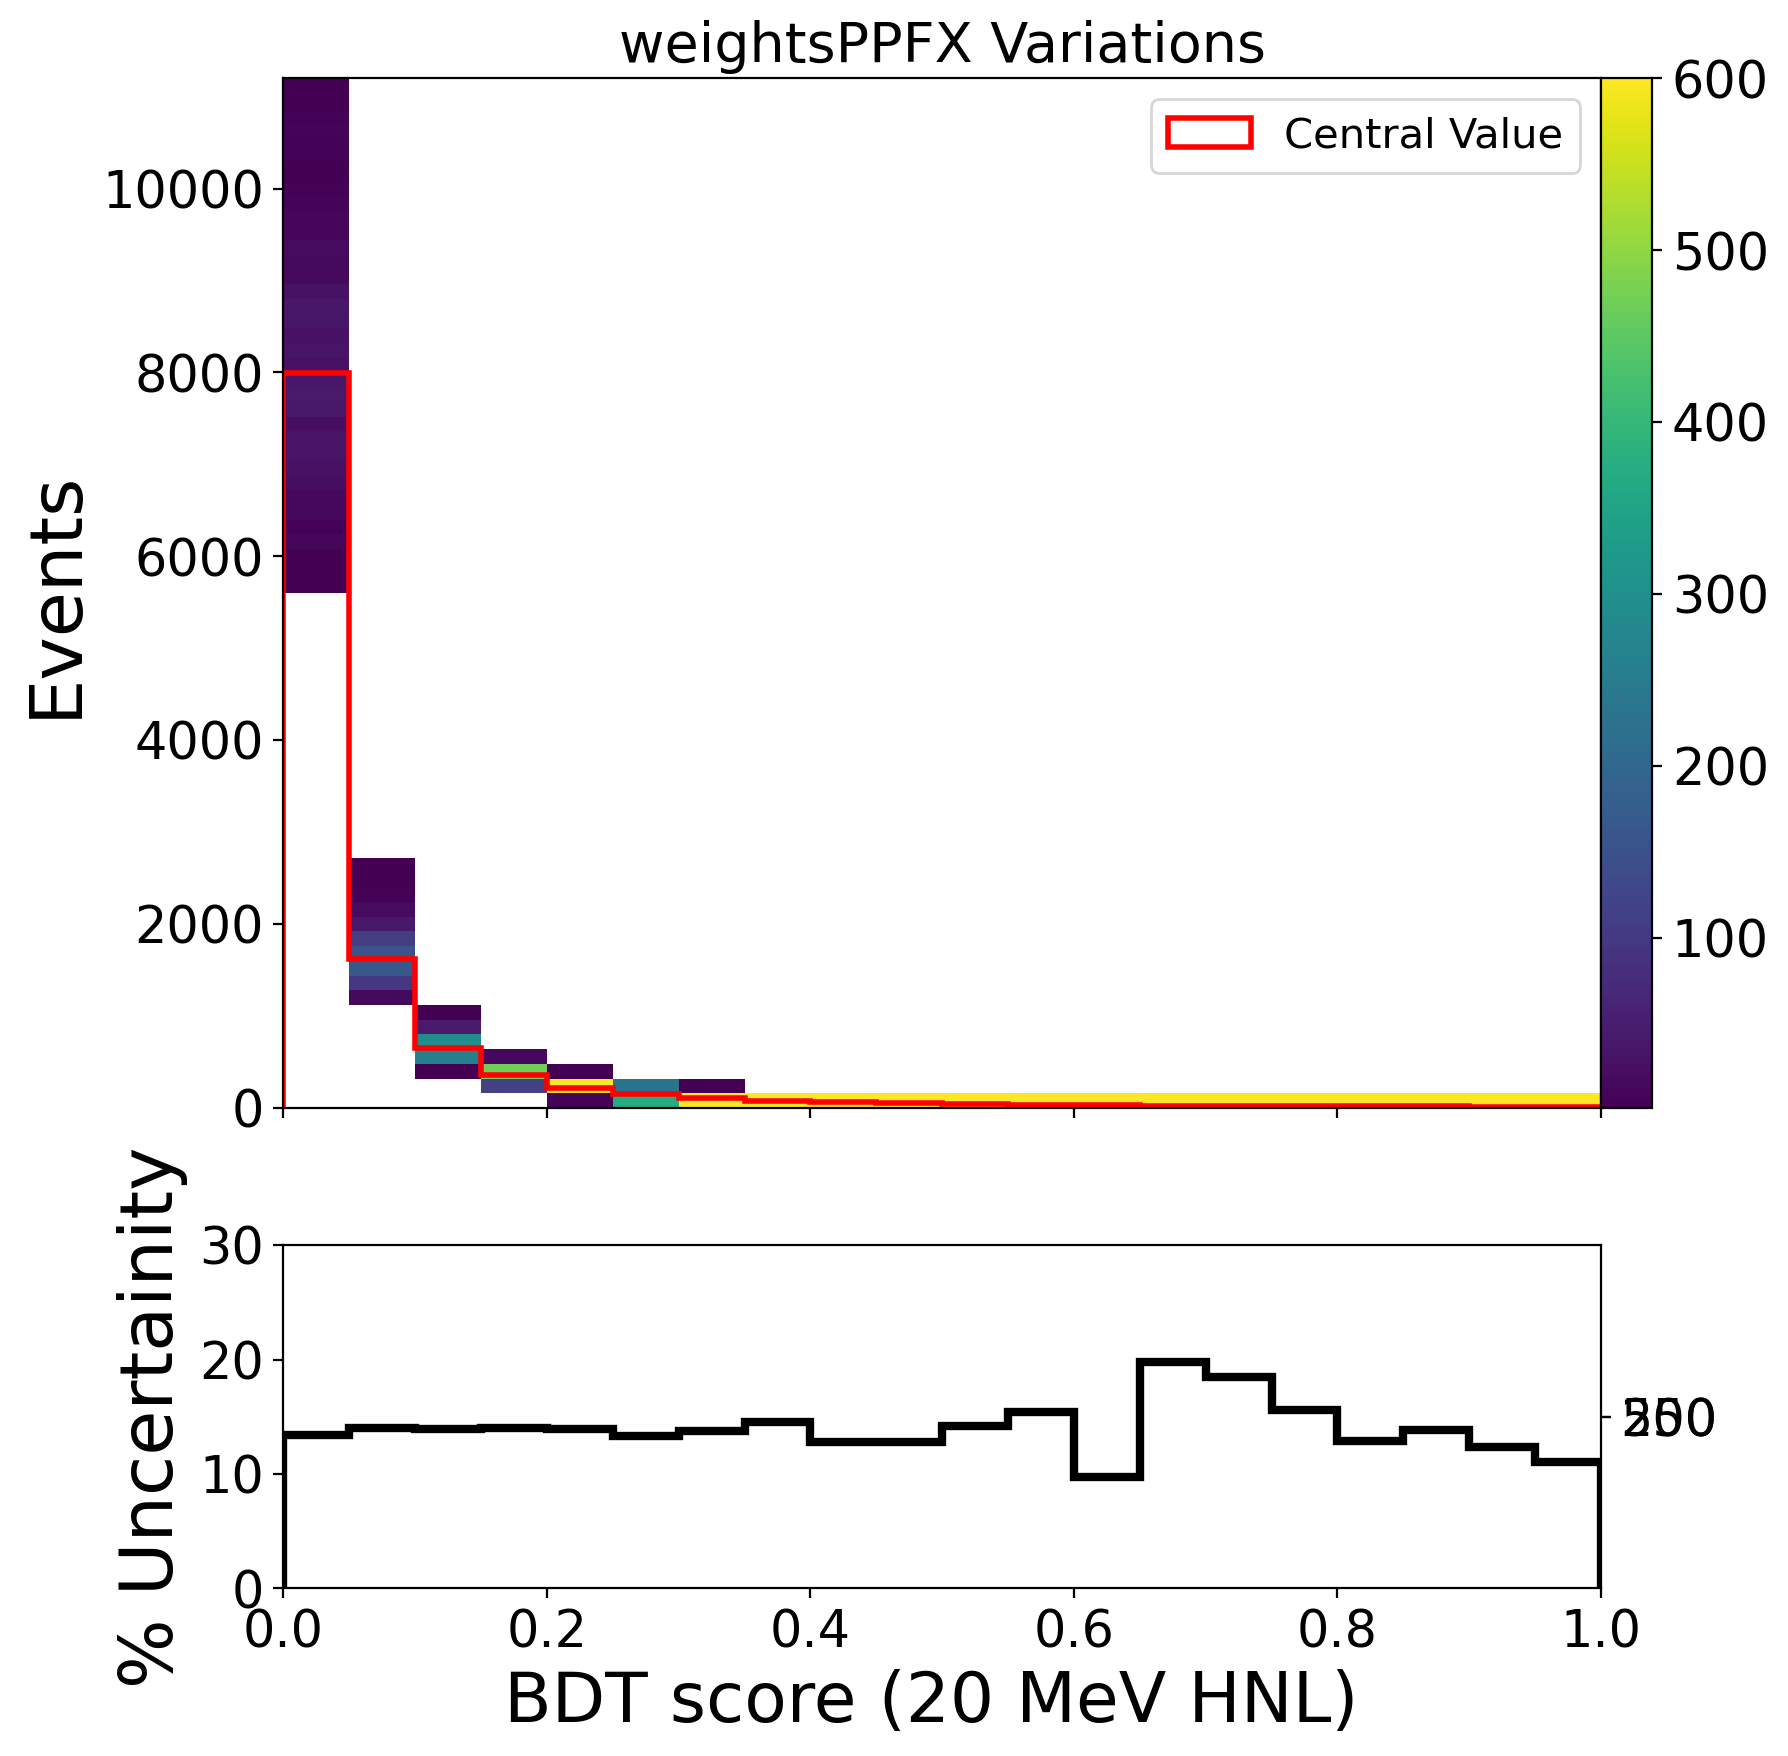

In [14]:
figsize=[10,10]
dpi=200
fig,ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=figsize,dpi=dpi)
plt.sca(ax[0])

bins=np.linspace(0,1.0,21)

print(bins)
bins_cent=(bins[:-1]+bins[1:])/2
bins_centlong=np.tile(bins_cent,600)

nybins=70

plt.title("weightsPPFX Variations",fontsize=20)

plt.hist(bins_cent,bins,weights=cv,color="red",histtype="step",label="Central Value",lw=2,linestyle='-')
plt.legend()
bins_cent=(bins[:-1]+bins[1:])/2
bins_centlong=np.tile(bins_cent,600)
# plt.step(bins_cent,cv+np.sqrt(np.diag(cov_gen)),lw=4,color="orange",ls="--")
# plt.step(bins_cent,cv-np.sqrt(np.diag(cov_gen)),lw=4,color="orange",ls="--")
# plt.colorbar()

plt.ylabel("Events")
plt.hist2d(bins_centlong,n_tot_ppfx.flatten(),bins=[bins,nybins],cmin=1,range=[[0,1.0],[0,max(cv)*1.4]],rasterized=True)
# cbaxes = inset_axes(ax[0], width="3%", height="50%", loc="right") 

# cbaxes = inset_axes(ax[0],[0.8, 0.1, 0.15, 0.15])
plt.colorbar(pad=0,use_gridspec=True)
# plt.yscale("log")
plt.ylim(0,max(cv)*1.4)
# plt.yscale("log")

plt.sca(ax[1])

# plt.step(bins_cent,np.sqrt(np.diag(cov_gen))/cv*100,color="black",where="mid")
plt.hist(bins_cent,bins,weights=np.sqrt(np.diag(cov_ppfx))/cv*100,color="black",histtype="step",lw=3,linestyle='-')
plt.ylim(0,30)
plt.ylabel("% Uncertainity")
plt.xlabel("BDT score (20 MeV HNL) ",fontsize=25)

cbar=plt.colorbar(shrink=0,pad=0,ticks=None) #Lol

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


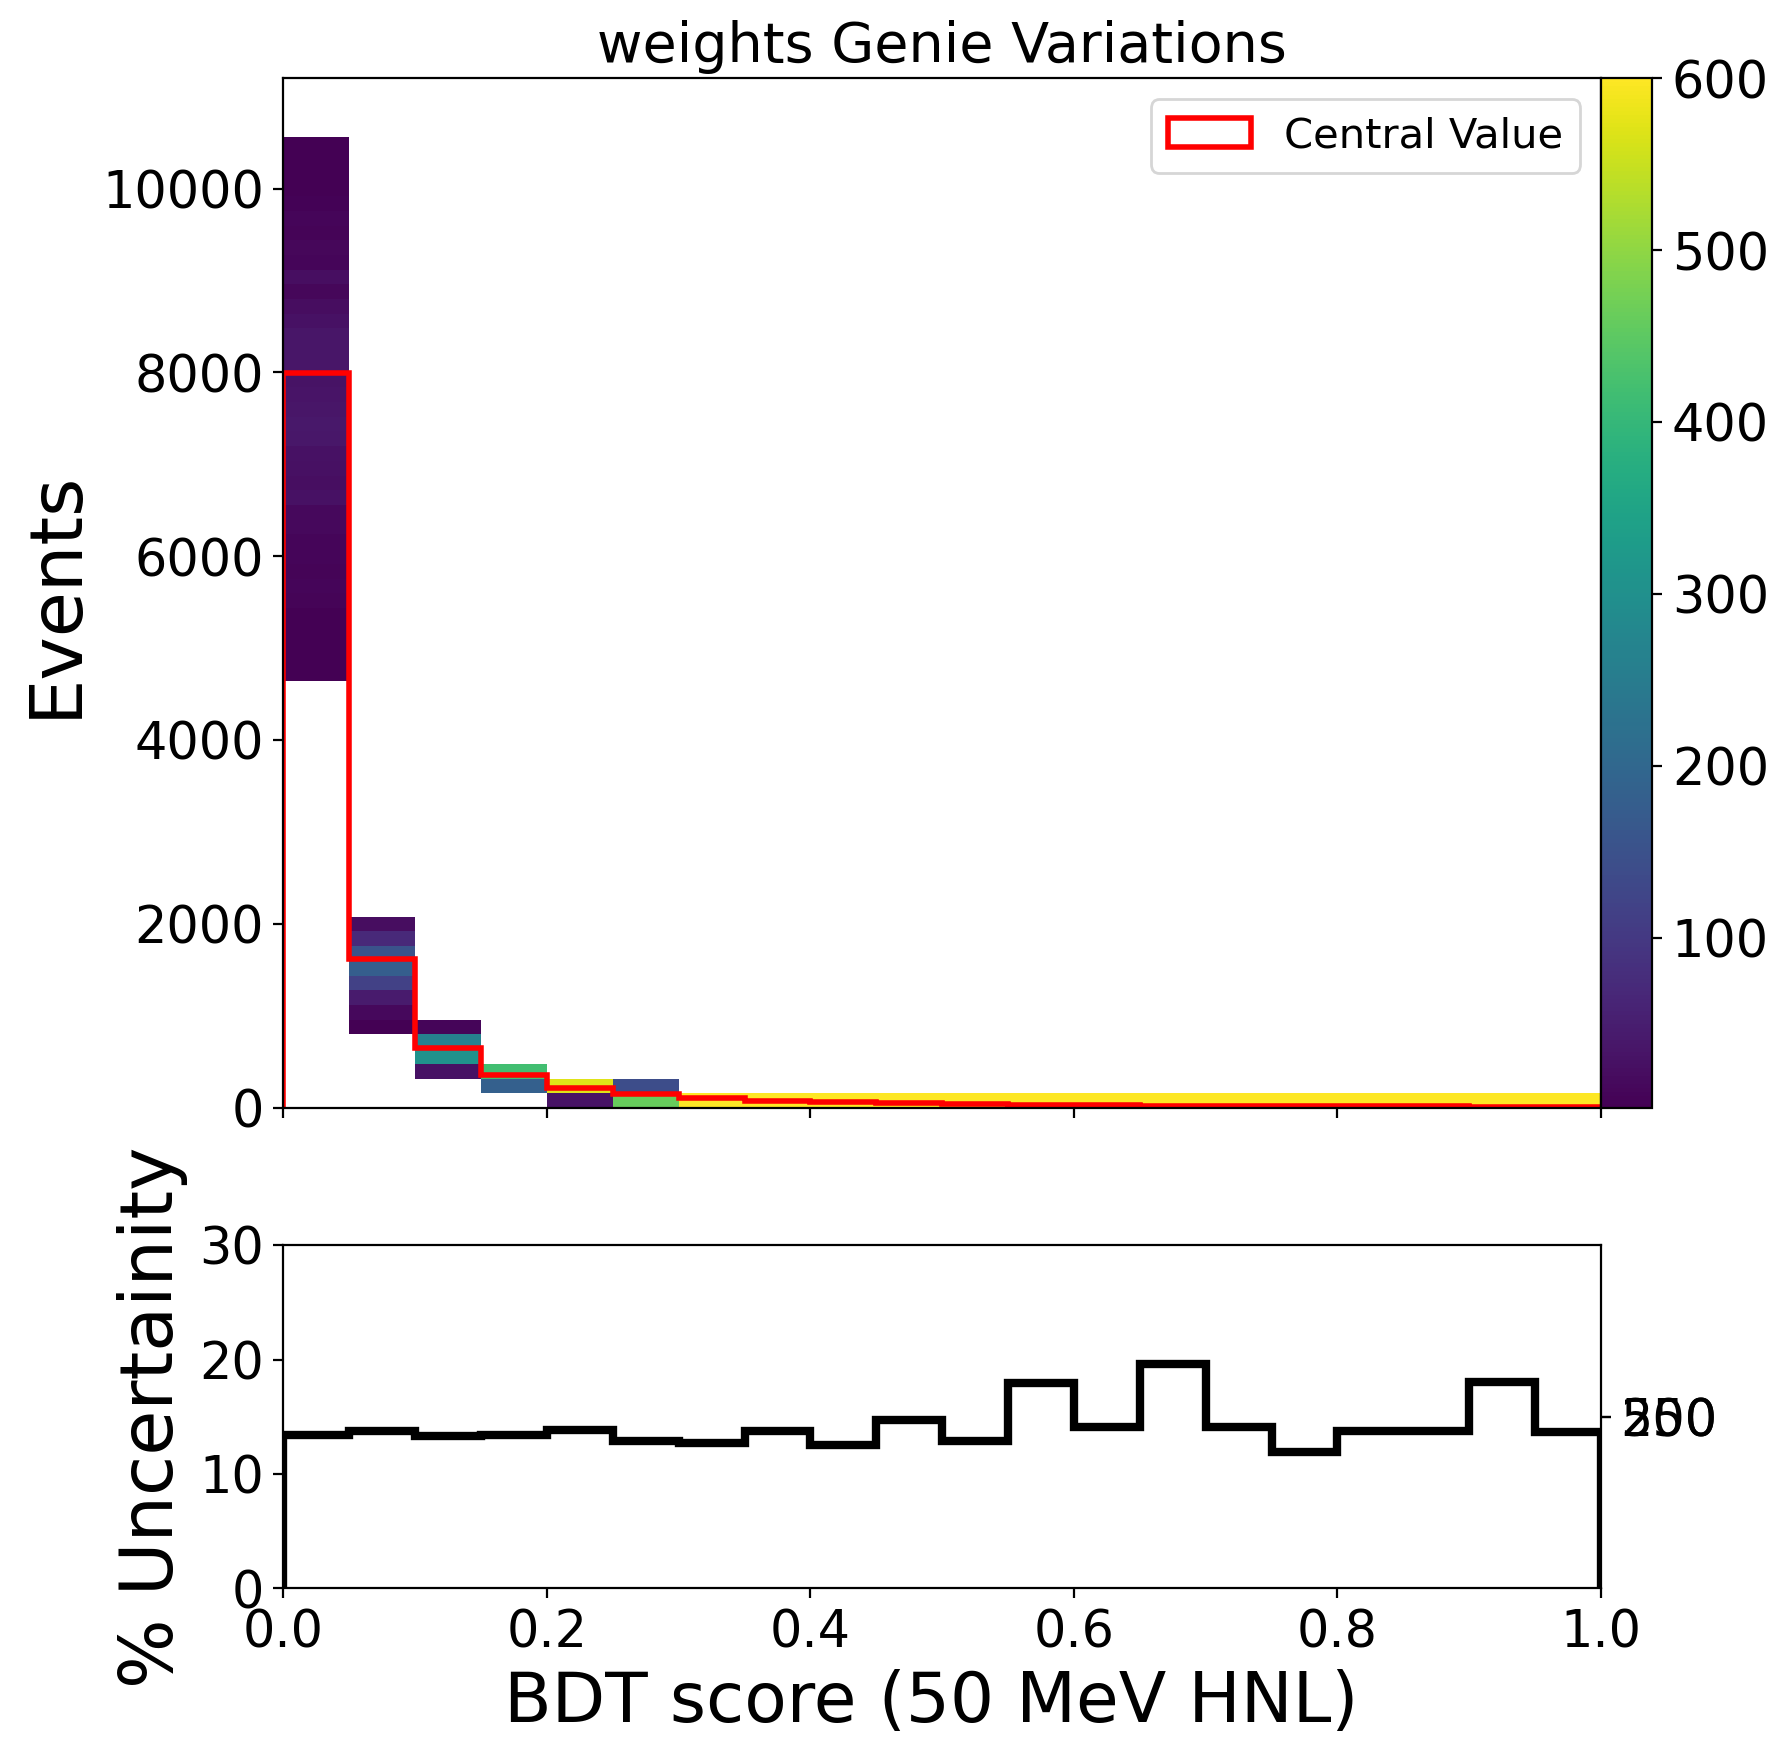

In [11]:
figsize=[10,10]
dpi=200
fig,ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=figsize,dpi=dpi)
plt.sca(ax[0])

bins=np.linspace(0,1.0,21)

print(bins)
bins_cent=(bins[:-1]+bins[1:])/2
bins_centlong=np.tile(bins_cent,600)

nybins=70

plt.title("weights Genie Variations",fontsize=20)

plt.hist(bins_cent,bins,weights=cv_genie,color="red",histtype="step",label="Central Value",lw=2,linestyle='-')
plt.legend()
bins_cent=(bins[:-1]+bins[1:])/2
bins_centlong=np.tile(bins_cent,600)
# plt.step(bins_cent,cv+np.sqrt(np.diag(cov_gen)),lw=4,color="orange",ls="--")
# plt.step(bins_cent,cv-np.sqrt(np.diag(cov_gen)),lw=4,color="orange",ls="--")
# plt.colorbar()

plt.ylabel("Events")
plt.hist2d(bins_centlong,n_tot_genie.flatten(),bins=[bins,nybins],cmin=1,range=[[0,1.0],[0,max(cv_genie)*1.4]],rasterized=True)
# cbaxes = inset_axes(ax[0], width="3%", height="50%", loc="right") 

# cbaxes = inset_axes(ax[0],[0.8, 0.1, 0.15, 0.15])
plt.colorbar(pad=0,use_gridspec=True)
# plt.yscale("log")
plt.ylim(0,max(cv_genie)*1.4)
# plt.yscale("log")

plt.sca(ax[1])

# plt.step(bins_cent,np.sqrt(np.diag(cov_gen))/cv*100,color="black",where="mid")
plt.hist(bins_cent,bins,weights=np.sqrt(np.diag(cov_genie))/cv_genie*100,color="black",histtype="step",lw=3,linestyle='-')
plt.ylim(0,30)
plt.ylabel("% Uncertainity")
plt.xlabel("BDT score (50 MeV HNL) ",fontsize=25)

cbar=plt.colorbar(shrink=0,pad=0,ticks=None) #Lol

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


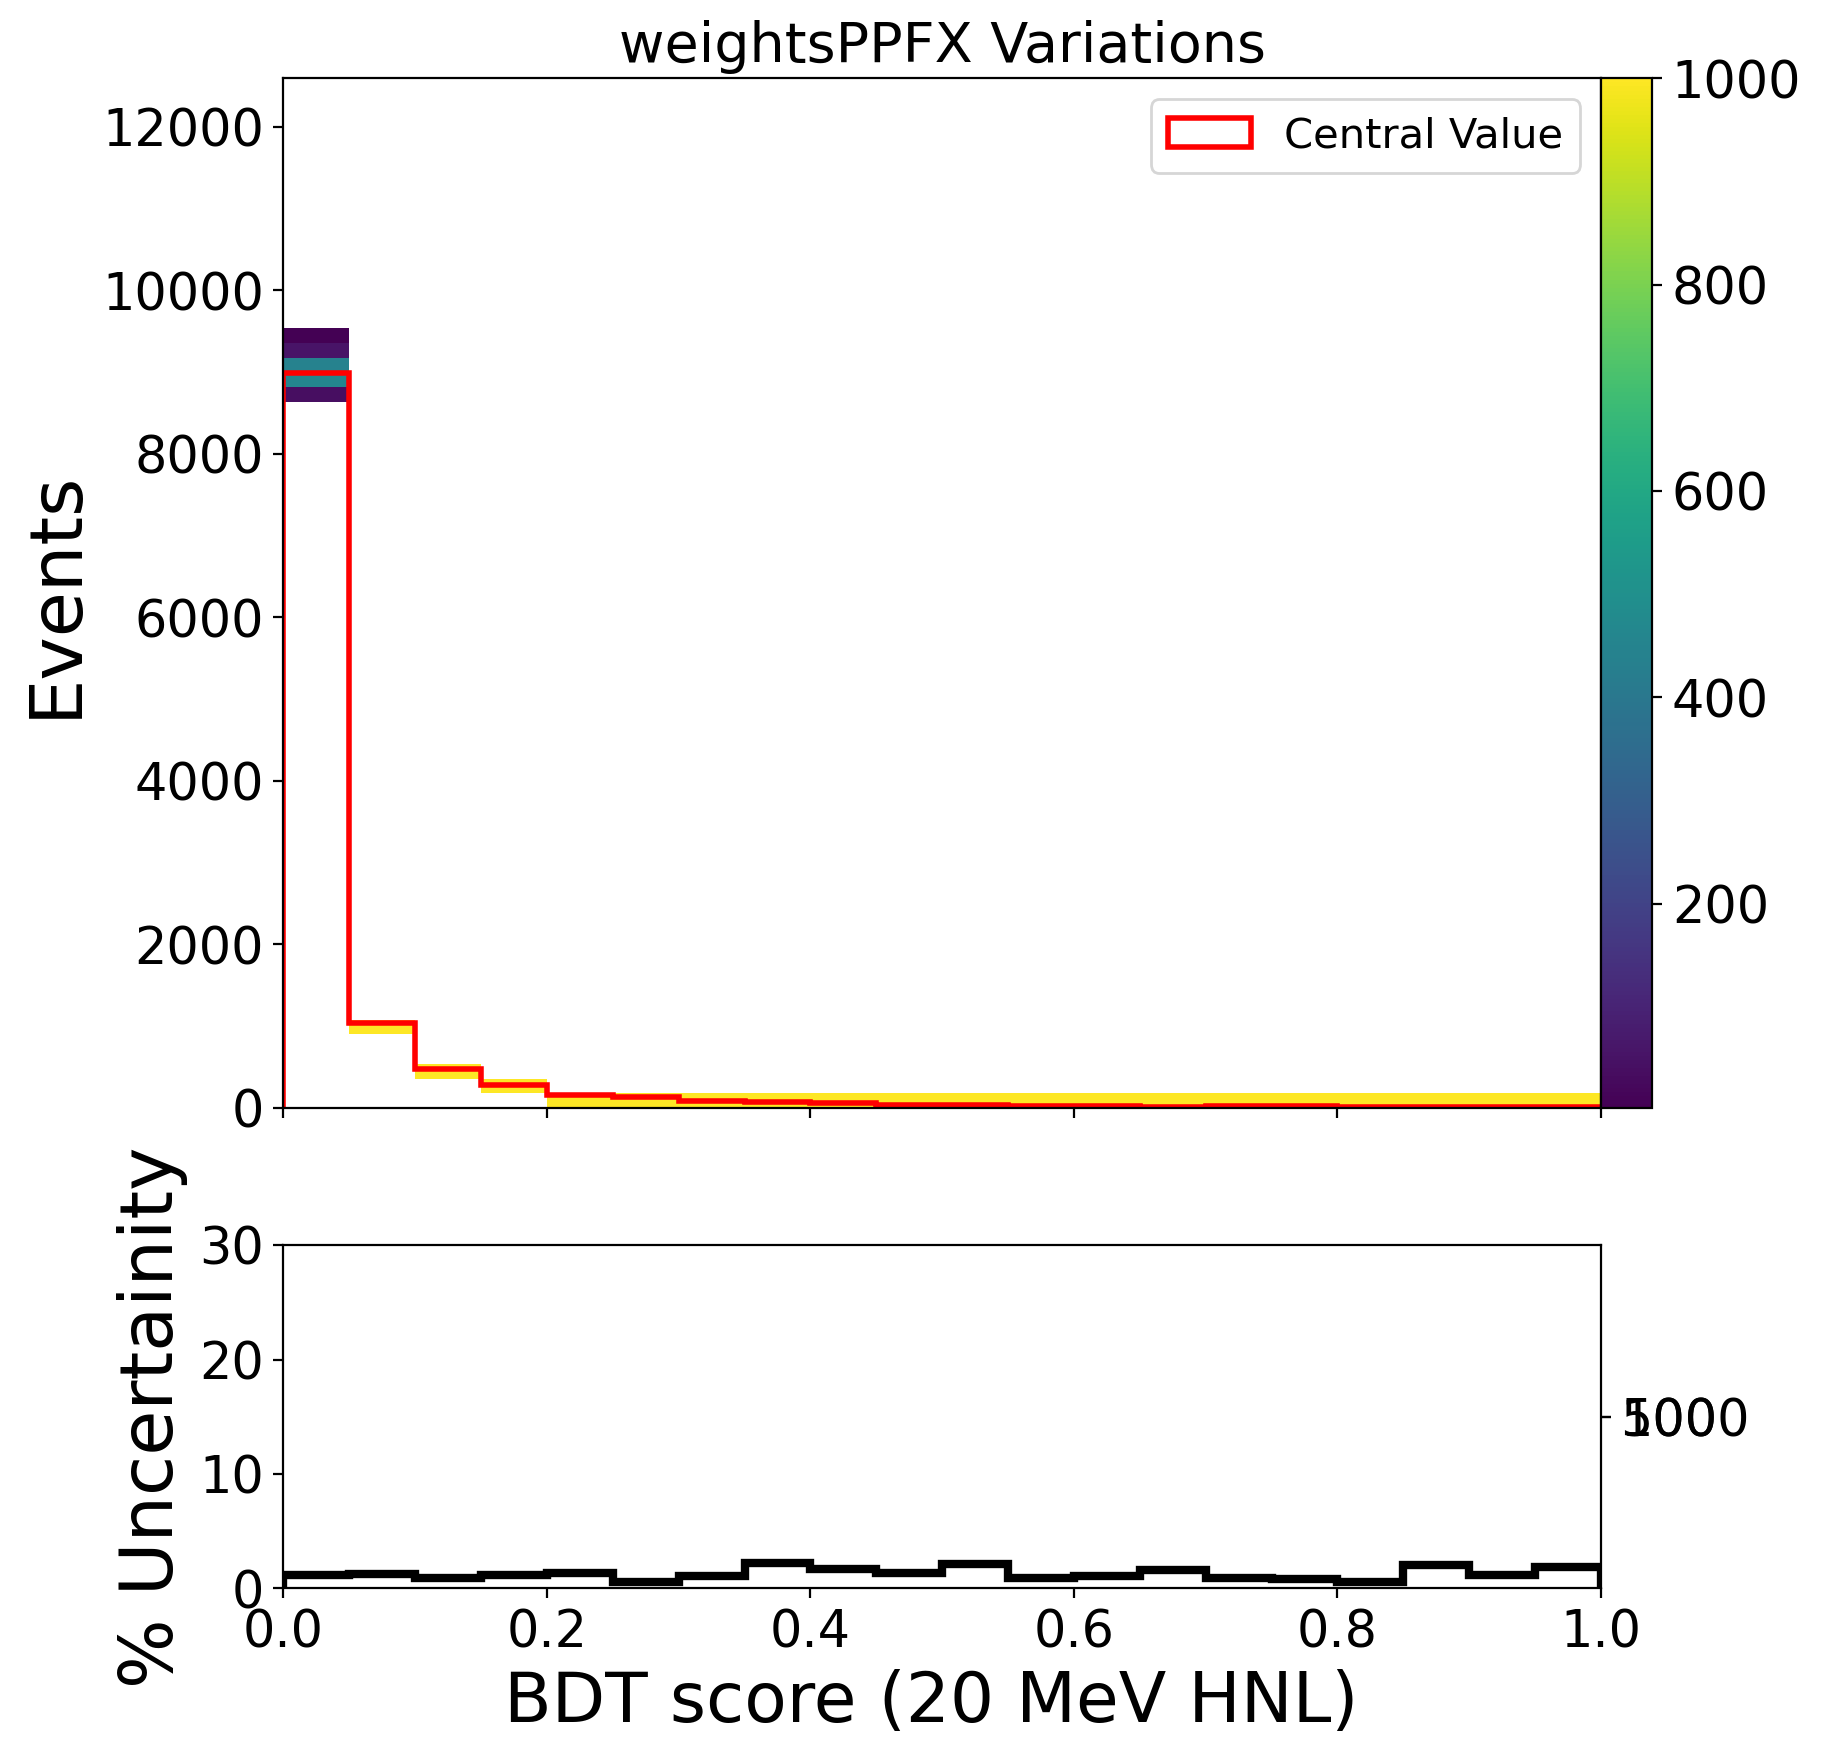

In [33]:
figsize=[10,10]
dpi=200
fig,ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=figsize,dpi=dpi)
plt.sca(ax[0])

bins=np.linspace(0,1.0,21)

print(bins)
bins_cent=(bins[:-1]+bins[1:])/2
bins_centlong=np.tile(bins_cent,600)

nybins=70

plt.title("weightsPPFX Variations",fontsize=20)

plt.hist(bins_cent,bins_reint,weights=cv_reint,color="red",histtype="step",label="Central Value",lw=2,linestyle='-')
plt.legend()
bins_cent=(bins_reint[:-1]+bins_reint[1:])/2
bins_centlong=np.tile(bins_cent,1000)
# plt.step(bins_cent,cv+np.sqrt(np.diag(cov_gen)),lw=4,color="orange",ls="--")
# plt.step(bins_cent,cv-np.sqrt(np.diag(cov_gen)),lw=4,color="orange",ls="--")
# plt.colorbar()

plt.ylabel("Events")
plt.hist2d(bins_centlong,n_tot_reint.flatten(),bins=[bins,nybins],cmin=1,range=[[0,1.0],[0,max(cv_reint)*1.4]],rasterized=True)
# cbaxes = inset_axes(ax[0], width="3%", height="50%", loc="right") 

# cbaxes = inset_axes(ax[0],[0.8, 0.1, 0.15, 0.15])
plt.colorbar(pad=0,use_gridspec=True)
# plt.yscale("log")
plt.ylim(0,max(cv_reint)*1.4)
# plt.yscale("log")

plt.sca(ax[1])

# plt.step(bins_cent,np.sqrt(np.diag(cov_gen))/cv*100,color="black",where="mid")
plt.hist(bins_cent,bins,weights=np.sqrt(np.diag(cov_reint))/cv*100,color="black",histtype="step",lw=3,linestyle='-')
plt.ylim(0,30)
plt.ylabel("% Uncertainity")
plt.xlabel("BDT score (20 MeV HNL) ",fontsize=25)

cbar=plt.colorbar(shrink=0,pad=0,ticks=None) #Lol

In [22]:
ppfx_unc = np.sqrt(np.diag(cov_ppfx))

print(type(ppfx_unc))
print(len(ppfx_unc))
print(ppfx_unc)

genie_unc = np.sqrt(np.diag(cov_genie))

print(type(genie_unc))
print(len(genie_unc))
print(genie_unc)

reint_unc = np.sqrt(np.diag(cov_reint))

print(type(reint_unc))
print(len(reint_unc))
print(reint_unc)

<class 'numpy.ndarray'>
20
[707.89989294 104.60043118  51.23389263  29.1282923   16.83089052
  13.82969146   9.98761494  10.39843544   6.64092843   5.5432272
   5.84080694   4.39932349   3.47276196   2.8035158    4.01497568
   1.67827867   2.2448077    2.55671728   1.92936088   1.64071029]
<class 'numpy.ndarray'>
20
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
<class 'numpy.ndarray'>
20
[7.51062892e+01 1.03161443e+01 4.82982138e+00 3.56588908e+00
 1.53729332e+00 1.07819135e+00 1.08350828e+00 9.09133433e-02
 1.19234507e-01 2.04317426e-01 2.58391430e-01 5.72514870e-01
 1.52914879e-01 3.33595659e-01 8.85934453e-02 3.00137729e-01
 3.56244944e-02 6.54751404e-01 2.36375884e-01 2.49963744e-01]


## Saving reweighting uncertainties as .root files

In [99]:
def SaveToRoot(nbins,xlims,uncertainty,name,fileName='test.root'):
    nBins = nbins
    binLimits = xlims
  ### Save files 
    rFile = ROOT.TFile(f'Uncertainties/{fileName}','RECREATE')
    tData1 = ROOT.TH1F(name,name,nBins,binLimits[0],binLimits[1])
    for i in range(nBins):
        tData1.SetBinContent(i+1,uncertainty[i])
    rFile.Write()
    rFile.Close()
    

In [100]:
HNL_mass = 20
SaveToRoot(20,[0,1.0],ppfx_unc,'ppfx_uncertainty',fileName=f'Test_1_{HNL_mass}MeV.root')